# Summarization


In this section we’ll take a look at how Transformer models can be used to condense long documents into summaries, a task known as text summarization. This is one of the most challenging NLP tasks as it requires a range of abilities, such as understanding long passages and generating coherent text that captures the main topics in a document. However, when done well, text summarization is a powerful tool that can speed up various business processes by relieving the burden of domain experts to read long documents in detail.



Although there already exist various fine-tuned models for summarization on the Hugging Face Hub, almost all of these are only suitable for English documents. So, to add a twist in this section, we’ll train a bilingual model for English and Spanish. By the end of this section, you’ll have a model that can summarize customer reviews.

## 1. Preparing a multilingual corpus


We’ll use the Multilingual Amazon Reviews Corpus to create our bilingual summarizer. This corpus consists of Amazon product reviews in six languages and is typically used to benchmark multilingual classifiers. However, since each review is accompanied by a short title, we can use the titles as the target summaries for our model to learn from! To get started, let’s download the English and Spanish subsets from the Hugging Face Hub:



In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

english_datasets = load_dataset(
    "json",
    data_files={
        "train": "https://huggingface.co/datasets/mteb/amazon_reviews_multi/resolve/main/en/train.jsonl",
        "validation": "https://huggingface.co/datasets/mteb/amazon_reviews_multi/resolve/main/en/validation.jsonl",
        "test": "https://huggingface.co/datasets/mteb/amazon_reviews_multi/resolve/main/en/test.jsonl"
    }
)
spanish_datasets = load_dataset(
    "json",
    data_files={
        "train": "https://huggingface.co/datasets/mteb/amazon_reviews_multi/resolve/main/es/train.jsonl",
        "validation": "https://huggingface.co/datasets/mteb/amazon_reviews_multi/resolve/main/es/validation.jsonl",
        "test": "https://huggingface.co/datasets/mteb/amazon_reviews_multi/resolve/main/es/test.jsonl"
    }
)
english_datasets

en/train.jsonl:   0%|          | 0.00/53.1M [00:00<?, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

es/train.jsonl:   0%|          | 0.00/48.7M [00:00<?, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 5000
    })
})

In [3]:
english_datasets["train"][15]

{'id': 'en_0056997',
 'text': "Does not play with with the two cases i bought ...\n\nDoes not play with with the two cases i bought. I'd request a refund but mines already cracked from the cases.",
 'label': 0,
 'label_text': '0'}

We can see our `text` column has a title in the first sentence, followed by its review. We will split this column and convert it into a `titles` and `reviews` column.

In [4]:
def split_title_review(batch):
    titles = []
    reviews = []
    for sample in batch["text"]:
        title, review = sample.split('\n\n', 1)
        titles.append(title)
        reviews.append(review)
    return {"titles": titles, "reviews": reviews}

In [5]:
en_datasets = english_datasets.map(split_title_review, batched=True)
es_datasets = spanish_datasets.map(split_title_review, batched=True)

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

As you can see, for each language there are 200,000 reviews for the `train` split, and 5,000 reviews for each of the `validation` and `test` splits. Let’s take a look at a few examples by creating a simple function that takes a random sample from the training set.



In [6]:
def show_examples(dataset, num_samples, seed):
    samples = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for sample in samples:
        print(f"{sample['titles']}")
        print(f"{sample['reviews']}")
        print()

In [7]:
show_examples(en_datasets, 3, 42)

Worked in front position, not rear
3 stars because these are not rear brakes as stated in the item description. At least the mount adapter only worked on the front fork of the bike that I got it for.

meh
Does it’s job and it’s gorgeous but mine is falling apart, I had to basically put it together again with hot glue

Can't beat these for the money
Bought this for handling miscellaneous aircraft parts and hanger "stuff" that I needed to organize; it really fit the bill. The unit arrived quickly, was well packaged and arrived intact (always a good sign). There are five wall mounts-- three on the top and two on the bottom. I wanted to mount it on the wall, so all I had to do was to remove the top two layers of plastic drawers, as well as the bottom corner drawers, place it when I wanted and mark it; I then used some of the new plastic screw in wall anchors (the 50 pound variety) and it easily mounted to the wall. Some have remarked that they wanted dividers for the drawers, and that they

In [8]:
en_datasets["train"] = en_datasets["train"].shuffle(seed=42).select(range(10_000))
es_datasets["train"] = es_datasets["train"].shuffle(seed=42).select(range(10_000))

Before we look at various models that are suitable for this task, we have one last bit of data preparation to do: combining the English and Spanish reviews as a single DatasetDict object. 🤗 Datasets provides a handy `concatenate_datasets()` function that (as the name suggests) will stack two `Dataset` objects on top of each other. So, to create our bilingual dataset, we’ll loop over each split, concatenate the datasets for that split, and shuffle the result to ensure our model doesn’t overfit to a single language:

In [9]:
from datasets import concatenate_datasets, DatasetDict

datasets = DatasetDict()

for split in en_datasets.keys():
    datasets[split] = concatenate_datasets(
        [en_datasets[split], es_datasets[split]]
    )
    datasets[split] = datasets[split].shuffle(seed=12)

show_examples(datasets, 3, 42)

Buena compra
La mochila está perfecta. Buscaba espacio y lo tiene (son 40 litros). Las cremalleras van genial. Cada departamento interior cumple la espectativa. La sujeción es muy buena. Buen material. Una mochila perfecta para ir al campo.

Fue un regalo y gusto
Era para un regalo a mi hijo le han encantado, tiene 7 años es cómodo y fácil de leer. En cuanto a resistencia todavía es pronto pero los materiales tienen buena pinta

Sent back
Sent this bag back. The gray area didn’t seem to have the waxy coating. No way the bag was going to hold up.



Now that we have a training corpus, one final thing to check is the distribution of words in the reviews and their titles. This is especially important for summarization tasks, where short reference summaries in the data can bias the model to only output one or two words in the generated summaries. To deal with this, we’ll filter out the examples with very short titles so that our model can produce more interesting summaries. Since we’re dealing with English and Spanish texts, we can use a rough heuristic to split the titles on whitespace and then use our trusty `Dataset.filter()` method as follows:



In [10]:
datasets = datasets.filter(lambda x: len(x["titles"].split()) > 3)

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Now that we’ve prepared our corpus, let’s take a look at a few possible Transformer models that one might fine-tune on it!



## 2. Models for text summarization

If you think about it, text summarization is a similar sort of task to machine translation: we have a body of text like a review that we’d like to “translate” into a shorter version that captures the salient features of the input. Accordingly, most Transformer models for summarization adopt the encoder-decoder architecture, although there are some exceptions like the GPT family of models which can also be used for summarization in few-shot settings. The following table lists some popular pretrained models that can be fine-tuned for summarization.



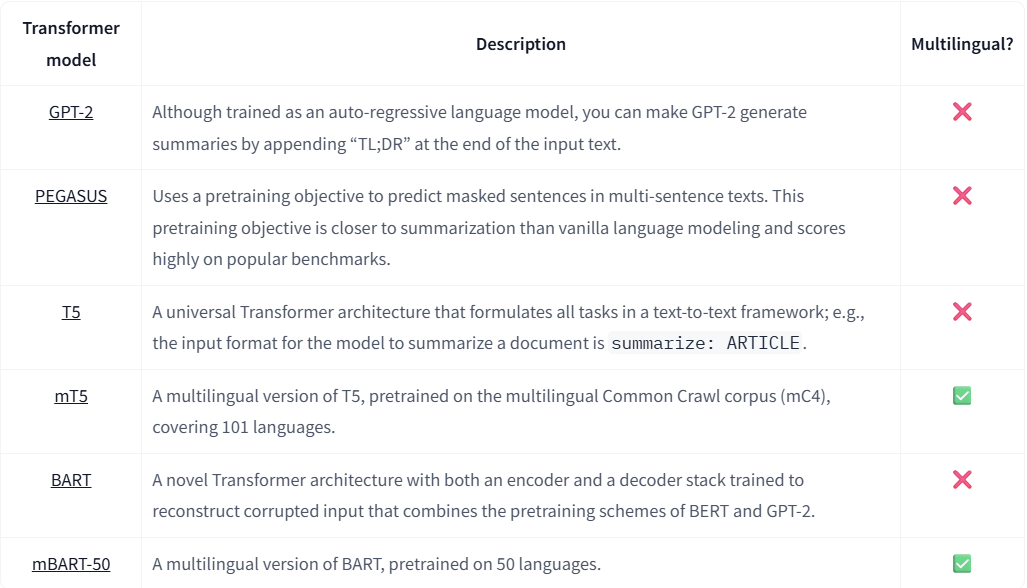

As you can see from this table, the majority of Transformer models for summarization (and indeed most NLP tasks) are monolingual. This is great if your task is in a “high-resource” language like English or German, but less so for the thousands of other languages in use across the world. Fortunately, there is a class of multilingual Transformer models, like mT5 and mBART, that come to the rescue. These models are pretrained using language modeling, but with a twist: instead of training on a corpus of one language, they are trained jointly on texts in over 50 languages at once!



We’ll focus on mT5, an interesting architecture based on T5 that was pretrained in a text-to-text framework. In T5, every NLP task is formulated in terms of a prompt prefix like `summarize:` which conditions the model to adapt the generated text to the prompt. As shown in the figure below, this makes T5 extremely versatile, as you can solve many tasks with a single model!



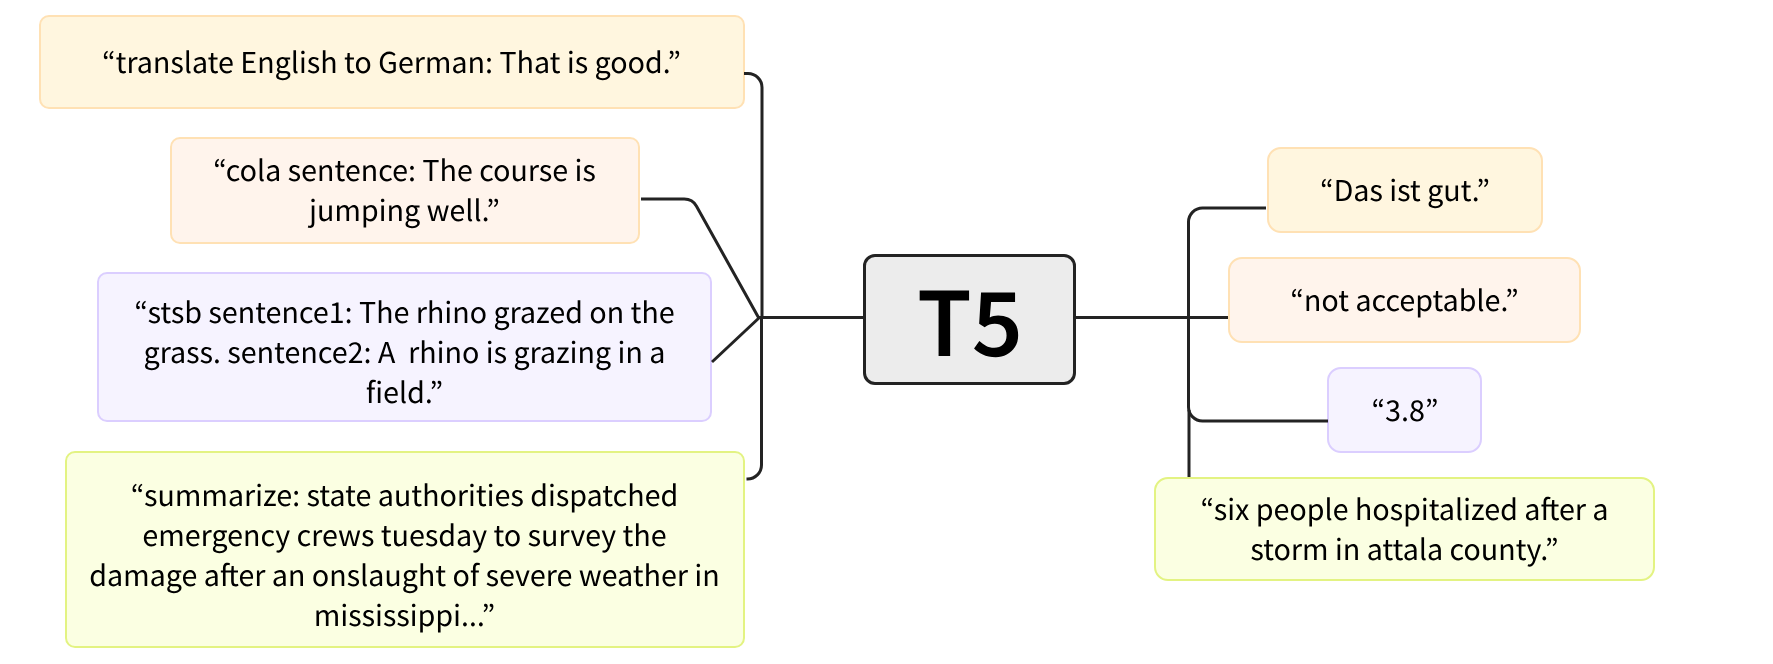

mT5 doesn’t use prefixes, but shares much of the versatility of T5 and has the advantage of being multilingual. Now that we’ve picked a model, let’s take a look at preparing our data for training.



## 3. Preprocessing the data

Our next task is to tokenize and encode our reviews and their titles. As usual, we begin by loading the tokenizer associated with the pretrained model checkpoint. We’ll use `mt5-small` as our checkpoint so we can fine-tune the model in a reasonable amount of time:



In [11]:
from transformers import AutoTokenizer

checkpoint = 'google/mt5-small'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

💡 In the early stages of your NLP projects, a good practice is to train a class of “small” models on a small sample of data. This allows you to debug and iterate faster toward an end-to-end workflow. Once you are confident in the results, you can always scale up the model by simply changing the model checkpoint!



Let’s test out the mT5 tokenizer on a small example:



In [12]:
inputs = tokenizer("I loved reading books and watching TVs.")
inputs

{'input_ids': [336, 259, 28387, 11807, 20743, 305, 259, 55634, 2208, 263, 260, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

['▁I',
 '▁',
 'loved',
 '▁reading',
 '▁books',
 '▁and',
 '▁',
 'watching',
 '▁TV',
 's',
 '.',
 '</s>']

The special Unicode character `▁` and `end-of-sequence` token `</s>` indicate that we’re dealing with the SentencePiece tokenizer, which is based on the Unigram segmentation algorithm. Unigram is especially useful for multilingual corpora since it allows SentencePiece to be agnostic about accents, punctuation, and the fact that many languages, like Japanese, do not have whitespace characters.

To tokenize our corpus, we have to deal with a subtlety associated with summarization: because our labels are also text, it is possible that they exceed the model’s maximum context size. This means we need to apply truncation to both the reviews and their titles to ensure we don’t pass excessively long inputs to our model. 

In [14]:
max_input_length = 512
max_label_length = 32

def preprocess_inputs(examples):
    model_inputs = tokenizer(
        examples["reviews"],
        max_length=max_input_length,
        truncation=True
    )
    labels = tokenizer(
        examples["titles"],
        max_length=max_label_length,
        truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

With `preprocess_function()`, it is then a simple matter to tokenize the whole corpus using the handy `Dataset.map()` function we’ve used extensively throughout this course:



In [15]:
tokenized_dataset = datasets.map(preprocess_inputs, batched=True)
tokenized_dataset

Map:   0%|          | 0/8395 [00:00<?, ? examples/s]

Map:   0%|          | 0/4213 [00:00<?, ? examples/s]

Map:   0%|          | 0/4203 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'titles', 'reviews', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8395
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'titles', 'reviews', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4213
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'titles', 'reviews', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4203
    })
})

Now that the corpus has been preprocessed, let’s take a look at some metrics that are commonly used for summarization. As we’ll see, there is no silver bullet when it comes to measuring the quality of machine-generated text.



## 4. Metrics for text summarization

In comparison to most of the other tasks we’ve covered in this course, measuring the performance of text generation tasks like summarization or translation is not as straightforward. For example, given a review like “I loved reading the Hunger Games”, there are multiple valid summaries, like “I loved the Hunger Games” or “Hunger Games is a great read”. Clearly, applying some sort of exact match between the generated summary and the label is not a good solution — even humans would fare poorly under such a metric, because we all have our own writing style.



For summarization, one of the most commonly used metrics is the ROUGE score (short for Recall-Oriented Understudy for Gisting Evaluation). The basic idea behind this metric is to compare a generated summary against a set of reference summaries that are typically created by humans. To make this more precise, suppose we want to compare the following two summaries:



In [16]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

One way to compare them could be to count the number of overlapping words, which in this case would be 6. However, this is a bit crude, so instead ROUGE is based on computing the precision and recall scores for the overlap.



We can do this easily in 🤗 Datasets by first installing the `rouge_score` package:

In [17]:
!pip install rouge_score

and then loading the ROUGE metric as follows:

In [18]:
import evaluate

rouge_score = evaluate.load("rouge")

Then we can use the `rouge_score.compute()` function to calculate all the metrics at once:



In [19]:
scores = rouge_score.compute(
    predictions=[generated_summary],
    references=[reference_summary]
)
scores

{'rouge1': np.float64(0.923076923076923),
 'rouge2': np.float64(0.7272727272727272),
 'rougeL': np.float64(0.923076923076923),
 'rougeLsum': np.float64(0.923076923076923)}

`rouge2` measures the overlap between bigrams (think the overlap of pairs of words), while `rougeL` and rougeLsum measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries. The “sum” in `rougeLsum` refers to the fact that this metric is computed over a whole summary, while `rougeL` is computed as the average over individual sentences.

We’ll use these ROUGE scores to track the performance of our model, but before doing that let’s do something every good NLP practitioner should do: create a strong, yet simple baseline!



## 5. Fine-tuning mT5 with the Trainer API


Fine-tuning a model for summarization is very similar to the other tasks we’ve covered in this chapter. The first thing we need to do is load the pretrained model from the `mt5-small` checkpoint. Since summarization is a sequence-to-sequence task, we can load the model with the `AutoModelForSeq2SeqLM` class, which will automatically download and cache the weights:



In [20]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/192 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

💡 If you’re wondering why you don’t see any warnings about fine-tuning the model on a downstream task, that’s because for sequence-to-sequence tasks we keep all the weights of the network. Compare this to our text classification model. where the head of the pretrained model was replaced with a randomly initialized network.



The next thing we need to do is log in to the Hugging Face Hub. If you’re running this code in a notebook, you can do so with the following utility function:



In [21]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

login(token=secret_value_0)

We’ll need to generate summaries in order to compute ROUGE scores during training. Fortunately, 🤗 Transformers provides dedicated `Seq2SeqTrainingArguments` and `Seq2SeqTrainer` classes that can do this for us automatically! To see how this works, let’s first define the hyperparameters and other arguments for our experiments:



In [22]:
checkpoint

'google/mt5-small'

### Creating a strong baseline


A common baseline for text summarization is to simply take the first three sentences of an article, often called the lead-3 baseline. We could use full stops to track the sentence boundaries, but this will fail on acronyms like “U.S.” or “U.N.” — so instead we’ll use the nltk library, which includes a better algorithm to handle these cases. You can install the package using `pip` as follows:



In [23]:
!pip install nltk

and then download the punctuation rules:



In [24]:
import nltk

nltk.download("punkt")

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
from transformers import Seq2SeqTrainingArguments

num_train_epochs = 3
batch_size = 4
num_steps = len(tokenized_dataset["train"]) // batch_size
model_name = checkpoint.split('/')[1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-amazon-reviews-es-en",
    eval_strategy='epoch',
    save_strategy='no',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=5.6e-5,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=num_steps,
    push_to_hub=True,
    fp16=True,
    report_to="none"    
)

We need to create a `compute_metrics()` function to create inputs for `rouge_score`.

In [ ]:
import numpy as np
import torch # Thêm torch để xử lý nếu preds đang là tensor

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id).astype(np.int64)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id).astype(np.int64)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    encoded_preds = ['\n'.join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    encoded_labels = ['\n'.join(sent_tokenize(label.strip())) for label in decoded_labels]

    results = rouge_score.compute(
        predictions=encoded_preds,
        references=encoded_labels,
        use_stemmer=True
    )
    
    results = {k: v for k, v in results.items()}
    return results

Next, we need to define a `data_collator`. Since our model is a sequence-to-sequence model, we will define a `DataCollatorForSeq2Seq` and remove old columns as our model/data collator doesn't expect these columns.

In [27]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
tokenized_dataset = tokenized_dataset.remove_columns(datasets["train"].column_names)

In [28]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    processing_class=tokenizer
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,3.145033,0.173753,0.076898,0.166941,0.167122
2,11.190059,3.041321,0.193996,0.094195,0.187408,0.187442
3,11.190059,2.999937,0.198310,0.097689,0.191384,0.191532


TrainOutput(global_step=3150, training_loss=9.941106460813492, metrics={'train_runtime': 3300.333, 'train_samples_per_second': 7.631, 'train_steps_per_second': 0.954, 'total_flos': 3821299833845760.0, 'train_loss': 9.941106460813492, 'epoch': 3.0})

During training, you should see the training loss decrease and the ROUGE scores increase with each epoch. Once the training is complete, you can see the final ROUGE scores by running `Trainer.evaluate()`:



In [29]:
trainer.evaluate()

{'eval_loss': 2.9999372959136963,
 'eval_rouge1': 0.1983101631474056,
 'eval_rouge2': 0.09768871447363248,
 'eval_rougeL': 0.19138428416541997,
 'eval_rougeLsum': 0.1915319653591985,
 'eval_runtime': 305.9064,
 'eval_samples_per_second': 13.772,
 'eval_steps_per_second': 1.723,
 'epoch': 3.0}

From the scores we can see that our model has handily outperformed our lead-3 baseline — nice! The final thing to do is push the model weights to the Hub, as follows:



In [30]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/arraypowerplay/mt5-small-amazon-reviews-es-en/commit/b17595c91009bae91e2dc8dccf7584e6d54f3bef', commit_message='Training complete', commit_description='', oid='b17595c91009bae91e2dc8dccf7584e6d54f3bef', pr_url=None, repo_url=RepoUrl('https://huggingface.co/arraypowerplay/mt5-small-amazon-reviews-es-en', endpoint='https://huggingface.co', repo_type='model', repo_id='arraypowerplay/mt5-small-amazon-reviews-es-en'), pr_revision=None, pr_num=None)

## 6. Create a custom training loop

### 6.1. Prepare everything for training

First, we need a `postprocess()` function to create inputs for `rouge_score`.


In [31]:
def postprocess(preds, labels):
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    encoded_preds = ['\n'.join(sent_tokenize(pred.strip())) for pred in preds]
    encoded_labels = ['\n'.join(sent_tokenize(label.strip())) for label in labels]

    return encoded_preds, encoded_labels

Then, we need to create a `DataLoader` object for the training loop.

In [32]:
import torch
from transformers import get_scheduler

num_train_epochs = 3
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenized_dataset.set_format("torch")

train_dataloader = torch.utils.data.DataLoader(
    tokenized_dataset["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)

eval_dataloader = torch.utils.data.DataLoader(
    tokenized_dataset["validation"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)


Loading weights:   0%|          | 0/192 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Finally, we need to set up a bit to push our model to the Hub.

In [33]:
from huggingface_hub import (
    get_full_repo_name, 
    create_repo, 
    HfApi
)

model_name = f"{model_name}-amazon-reviews-es-en-accelerate"
repo_name = get_full_repo_name(model_name)
create_repo(repo_name, exist_ok=True)
api = HfApi()

### 6.2. Implement the training loop

And the training loop can be implemented as follows:

In [ ]:
from accelerate import Accelerator
from tqdm.auto import tqdm

accelerator = Accelerator(mixed_precision="fp16")

num_training_steps = len(train_dataloader) * num_train_epochs
optimizer = torch.optim.AdamW(model.parameters(), lr=5.6e-5)
gradient_accumulation_steps = 2

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=0,
)

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

progress = tqdm(range(num_training_steps))
output_dir = "results-mt5-finetuned-squad-accelerate"

for epoch in range(num_train_epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        if (step + 1) % gradient_accumulation_steps == 0:
            accelerator.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress.update(1)
    
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            preds = accelerator.unwrap_model(model).generate(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
        labels = batch["labels"]
        preds = accelerator.pad_across_processes(
            preds, dim=-1, pad_index=tokenizer.pad_token_id
        )
        preds_gathered = accelerator.gather(preds)
        labels = accelerator.pad_across_processes(
            labels, dim=-1, pad_index=-100
        )
        labels_gathered = accelerator.gather(labels)
        
        if isinstance(preds_gathered, tuple):
            preds_gathered = preds_gathered[0]
        encoded_preds, encoded_labels = postprocess(preds_gathered, labels_gathered)
        rouge_score.add_batch(predictions=encoded_preds, references=encoded_labels)

    results = rouge_score.compute()
    results = {k: v for k, v in results.items()}
    print(f"epoch {epoch + 1}\n{results}")
    
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        api.upload_folder(
            repo_id=repo_name,
            folder_path=output_dir,
            commit_message=f"Training progress in epoch {epoch + 1}."
        )